In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv
pd.options.display.max_columns = None
pd.options.display.max_rows = None


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/av-janatahack-machine-learning-in-agriculture/sample_submission.csv
/kaggle/input/av-janatahack-machine-learning-in-agriculture/test.csv
/kaggle/input/av-janatahack-machine-learning-in-agriculture/train.csv


In [2]:
import seaborn as sns
from matplotlib import *
from matplotlib import pyplot as plt
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier

In [3]:
train_data = pd.read_csv('/kaggle/input/av-janatahack-machine-learning-in-agriculture/train.csv')
test_data = pd.read_csv('/kaggle/input/av-janatahack-machine-learning-in-agriculture/test.csv')
sample_submission = pd.read_csv('/kaggle/input/av-janatahack-machine-learning-in-agriculture/sample_submission.csv')
train_data.columns = train_data.columns.str.lower().str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
test_data.columns = test_data.columns.str.lower().str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [4]:
print('Train Data Shape: ', train_data.shape)
print('Test Data Shape: ', test_data.shape)
train_data.head()

Train Data Shape:  (88858, 10)
Test Data Shape:  (59310, 9)


,id,estimated_insects_count,crop_type,soil_type,pesticide_use_category,number_doses_week,number_weeks_used,number_weeks_quit,season,crop_damage
0,F00000001,188,1,0,1,0,0.0,0,1,0
1,F00000003,209,1,0,1,0,0.0,0,2,1
2,F00000004,257,1,0,1,0,0.0,0,2,1
3,F00000005,257,1,1,1,0,0.0,0,2,1
4,F00000006,342,1,0,1,0,0.0,0,2,1


In [5]:
train_data.dtypes

id                          object
estimated_insects_count      int64
crop_type                    int64
soil_type                    int64
pesticide_use_category       int64
number_doses_week            int64
number_weeks_used          float64
number_weeks_quit            int64
season                       int64
crop_damage                  int64
dtype: object

In [6]:
train_data.isnull().sum()

id                            0
estimated_insects_count       0
crop_type                     0
soil_type                     0
pesticide_use_category        0
number_doses_week             0
number_weeks_used          9000
number_weeks_quit             0
season                        0
crop_damage                   0
dtype: int64

In [7]:
train_data.nunique()

id                         88858
estimated_insects_count       71
crop_type                      2
soil_type                      2
pesticide_use_category         3
number_doses_week             20
number_weeks_used             64
number_weeks_quit             51
season                         3
crop_damage                    3
dtype: int64

In [8]:
print('Season volume:\n', train_data.season.value_counts())
print('Crop volume:\n', train_data.crop_type.value_counts())
print('Soil volume:\n', train_data.soil_type.value_counts())
print('Pesticide volume:\n', train_data.pesticide_use_category.value_counts())
print('Soil wise crop damage volume:\n', train_data.groupby('soil_type')['crop_damage'].value_counts())
print('Crop wise crop damage volume:\n', train_data.groupby('crop_type')['crop_damage'].value_counts())
print('Season wise crop damage volume:\n', train_data.groupby('season')['crop_damage'].value_counts())

Season volume:
 2    44210
1    26902
3    17746
Name: season, dtype: int64
Crop volume:
 0    63589
1    25269
Name: crop_type, dtype: int64
Soil volume:
 0    48124
1    40734
Name: soil_type, dtype: int64
Pesticide volume:
 2    63709
3    24312
1      837
Name: pesticide_use_category, dtype: int64
Soil wise crop damage volume:
 soil_type  crop_damage
0          0              39841
           1               6953
           2               1330
1          0              34397
           1               5354
           2                983
Name: crop_damage, dtype: int64
Crop wise crop damage volume:
 crop_type  crop_damage
0          0              52778
           1               9204
           2               1607
1          0              21460
           1               3103
           2                706
Name: crop_damage, dtype: int64
Season wise crop damage volume:
 season  crop_damage
1       0              22493
        1               3748
        2                661
2

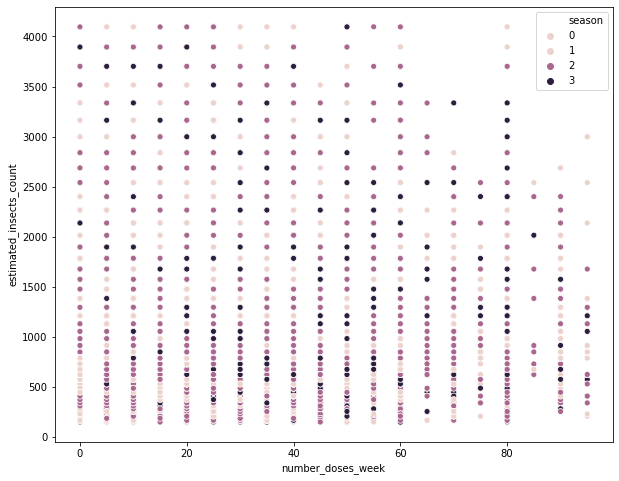

In [9]:
plt.figure(figsize = (10, 8))
sns.scatterplot(x = 'number_doses_week', y = 'estimated_insects_count', hue = 'season', data = train_data)
plt.show()

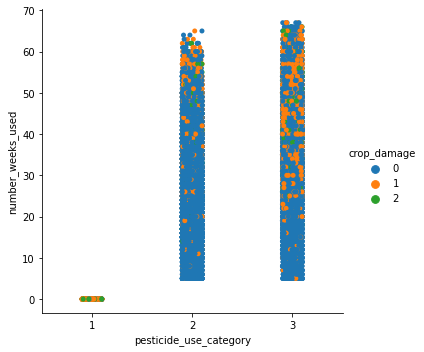

In [10]:
sns.catplot(x = 'pesticide_use_category', y = 'number_weeks_used', data = train_data, hue = 'crop_damage')
sns.despine()

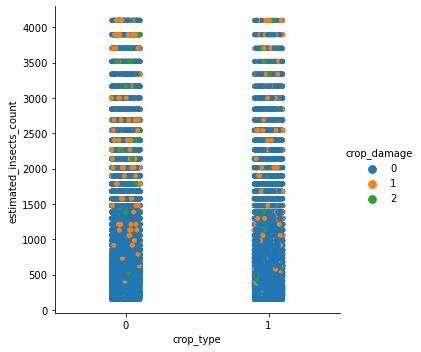

In [11]:
sns.catplot(x = 'crop_type', y = 'estimated_insects_count', data = train_data, hue = 'crop_damage')
sns.despine()

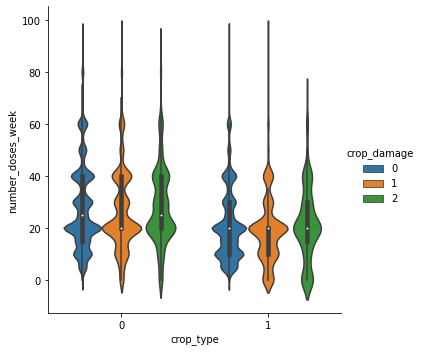

In [12]:
sns.catplot(x = 'crop_type', y = 'number_doses_week', kind = 'violin', data = train_data, hue = 'crop_damage')
sns.despine()

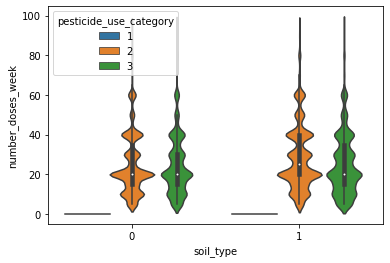

In [13]:
ax = sns.violinplot(x = 'soil_type', y = 'number_doses_week', hue = 'pesticide_use_category', data = train_data)

There is more damage to crops getting less than 50 dosages per week 

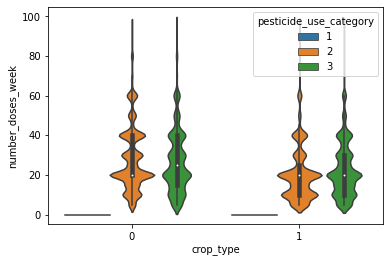

In [14]:
ax = sns.violinplot(x = 'crop_type', y = 'number_doses_week', hue = 'pesticide_use_category', data = train_data)

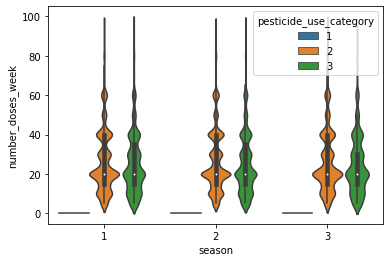

In [15]:
ax = sns.violinplot(x = 'season', y = 'number_doses_week', hue = 'pesticide_use_category', data = train_data)

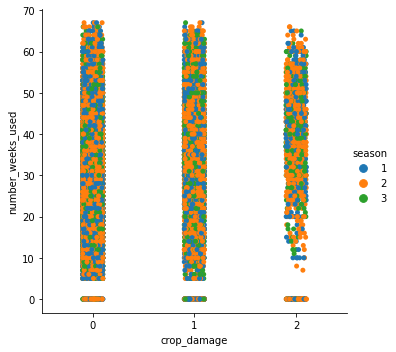

In [16]:
sns.catplot(x = 'crop_damage', y = 'number_weeks_used', data = train_data, hue = 'season')
sns.despine()

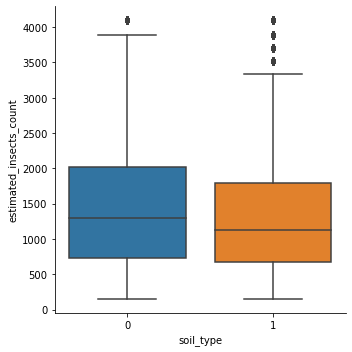

In [17]:
sns.catplot(x = "soil_type", y = 'estimated_insects_count', kind = 'box', data = train_data)
sns.despine()

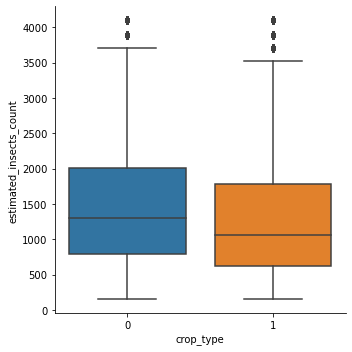

In [18]:
sns.catplot(x = "crop_type", y = 'estimated_insects_count', kind = 'box', data = train_data)
sns.despine()

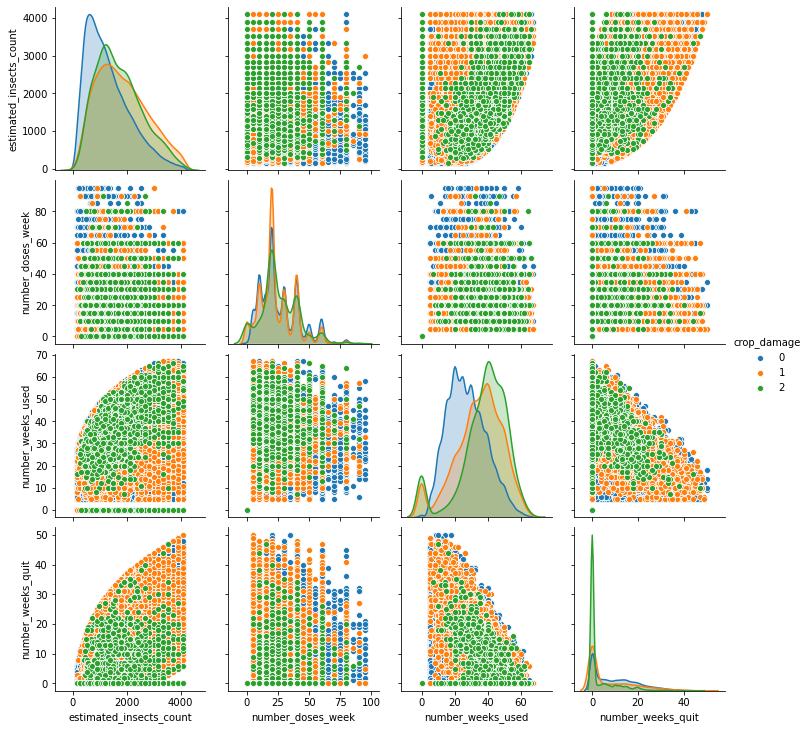

In [19]:
sns.pairplot(train_data[['estimated_insects_count', 'number_doses_week', 'crop_damage', 'number_weeks_used', 'number_weeks_quit']], hue = 'crop_damage')
sns.despine()

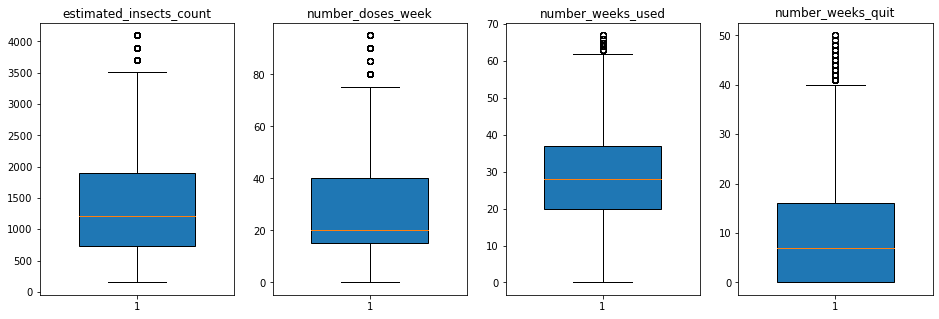

In [20]:
plt.figure(figsize = (16, 5))
for i in range(1, 5):
    cols = ['estimated_insects_count', 'number_doses_week', 'number_weeks_used', 'number_weeks_quit']
    col = cols[i-1]
    ax = plt.subplot(1, 4, i)
    plt.boxplot(train_data.loc[~(train_data[col].isnull()), col], patch_artist = True, widths = 0.6)
    ax.set_title(col)

## Handling missing values

### Converting IDs to numbers and reordering according to observation sequence

In [21]:
train_data['id'] = train_data['id'].apply(lambda x: x.split('F')[1])
test_data['id'] = test_data['id'].apply(lambda x: x.split('F')[1])
train_data.loc[(train_data['pesticide_use_category'] == 1), 'number_weeks_used'] = 0

In [22]:
testData = test_data.copy()
testData['crop_damage'] = -1
train_data['flag'] = 'train'
test_data['flag'] = 'test'
#master_data = train_data[train_data.columns[~train_data.columns.isin(['crop_damage'])]].append(test_data[train_data.columns[~train_data.columns.isin(['crop_damage'])]])
master_data = train_data.append(testData)
master_data = master_data.sort_values(by = ['id'], ascending = (True))
master_data = master_data.reset_index(drop = True)

In [23]:
master_data['soil_type_damage'] = master_data.sort_values(['id']).groupby(['soil_type'])['crop_damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values
master_data['estimated_insects_count_damage'] = master_data.sort_values(['id']).groupby(['estimated_insects_count'])['crop_damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values
master_data['crop_type_damage'] = master_data.sort_values(['id']).groupby(['crop_type'])['crop_damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values
master_data['pesticide_use_category_damage'] = master_data.sort_values(['id']).groupby(['pesticide_use_category'])['crop_damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values
master_data['season_damage'] = master_data.sort_values(['id']).groupby(['season'])['crop_damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values
master_data['soil_type_damage_lag2'] = master_data.sort_values(['id']).groupby(['soil_type'])['crop_damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values
master_data['estimated_insects_count_damage_lag2'] = master_data.sort_values(['id']).groupby(['estimated_insects_count'])['crop_damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values
master_data['crop_type_damage_lag2'] = master_data.sort_values(['id']).groupby(['crop_type'])['crop_damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values
master_data['pesticide_use_category_damage_lag2'] = master_data.sort_values(['id']).groupby(['pesticide_use_category'])['crop_damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values
master_data['season_damage_lag2'] = master_data.sort_values(['id']).groupby(['season'])['crop_damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values


In [24]:
master_data['crop_damage_lag1'] = master_data['crop_damage'].shift(fill_value=-999)
master_data['estimated_insects_count_lag1'] = master_data['estimated_insects_count'].shift(fill_value=-999)
master_data['crop_type_lag1'] = master_data['crop_type'].shift(fill_value=-999)
master_data['soil_type_lag1'] = master_data['soil_type'].shift(fill_value=-999)
master_data['pesticide_use_category_lag1'] = master_data['pesticide_use_category'].shift(fill_value=-999)
master_data['number_doses_week_lag1'] = master_data['number_doses_week'].shift(fill_value=-999)
master_data['number_weeks_used_lag1'] = master_data['number_weeks_used'].shift(fill_value=-999)
master_data['number_weeks_quit_lag1'] = master_data['number_weeks_quit'].shift(fill_value=-999)
master_data['season_lag1'] = master_data['season'].shift(fill_value=-999)

master_data['crop_damage_lag2'] = master_data['crop_damage'].shift(periods=2,fill_value=-999)
master_data['estimated_insects_count_lag2'] = master_data['estimated_insects_count'].shift(periods=2,fill_value=-999)
master_data['crop_type_lag2'] = master_data['crop_type'].shift(fill_value=-999)
master_data['soil_type_lag2'] = master_data['soil_type'].shift(fill_value=-999)
master_data['pesticide_use_category_lag2'] = master_data['pesticide_use_category'].shift(periods=2,fill_value=-999)
master_data['number_doses_week_lag2'] = master_data['number_doses_week'].shift(periods=2,fill_value=-999)
master_data['number_weeks_used_lag2'] = master_data['number_weeks_used'].shift(periods=2,fill_value=-999)
master_data['number_weeks_quit_lag2'] = master_data['number_weeks_quit'].shift(periods=2,fill_value=-999)
master_data['season_lag2'] = master_data['season'].shift(periods=2,fill_value=-999)

In [25]:
train_data, test_data = master_data[master_data.flag == 'train'], master_data[master_data.flag == 'test']

In [26]:
impute = -999

In [27]:
train_data = train_data.drop(['flag'], axis = 1)
test_data = test_data.drop(['flag'], axis = 1)
test_data = test_data.drop(['crop_damage'], axis = 1)

In [28]:
print(train_data.shape, test_data.shape)

(88858, 38) (0, 37)


In [29]:
train_data.head()

,id,estimated_insects_count,crop_type,soil_type,pesticide_use_category,number_doses_week,number_weeks_used,number_weeks_quit,season,crop_damage,soil_type_damage,estimated_insects_count_damage,crop_type_damage,pesticide_use_category_damage,season_damage,soil_type_damage_lag2,estimated_insects_count_damage_lag2,crop_type_damage_lag2,pesticide_use_category_damage_lag2,season_damage_lag2,crop_damage_lag1,estimated_insects_count_lag1,crop_type_lag1,soil_type_lag1,pesticide_use_category_lag1,number_doses_week_lag1,number_weeks_used_lag1,number_weeks_quit_lag1,season_lag1,crop_damage_lag2,estimated_insects_count_lag2,crop_type_lag2,soil_type_lag2,pesticide_use_category_lag2,number_doses_week_lag2,number_weeks_used_lag2,number_weeks_quit_lag2,season_lag2
0,00000001,188,1,0,1,0,0.0,0,1,0,-999.000000,-999.0,-999.00,-999.00,-999.000000,-999.0,-999.0,-999.00,-999.00,-999.000000,-999,-999,-999,-999,-999,-999,-999.0,-999,-999,-999,-999,-999,-999,-999,-999,-999.0,-999,-999
2,00000003,209,1,0,1,0,0.0,0,2,1,0.000000,-999.0,-0.50,-0.50,-1.000000,-999.0,-999.0,0.00,0.00,-999.000000,-1,188,1,1,1,0,NaN,0,2,0,188,1,1,1,0,0.0,0,1
3,00000004,257,1,0,1,0,0.0,0,2,1,0.500000,-999.0,0.00,0.00,0.000000,0.0,-999.0,-0.50,-0.50,-1.000000,1,209,1,0,1,0,0.0,0,2,-1,188,1,0,1,0,NaN,0,2
4,00000005,257,1,1,1,0,0.0,0,2,1,-1.000000,1.0,0.25,0.25,0.333333,-999.0,-999.0,0.00,0.00,0.000000,1,257,1,0,1,0,0.0,0,2,1,209,1,0,1,0,0.0,0,2
5,00000006,342,1,0,1,0,0.0,0,2,1,0.666667,-999.0,0.40,0.40,0.500000,0.5,-999.0,0.25,0.25,0.333333,1,257,1,1,1,0,0.0,0,2,1,257,1,1,1,0,0.0,0,2


In [30]:
train_data['number_weeks_used'] = train_data['number_weeks_used'].apply(lambda x: impute if pd.isna(x) else x)
test_data['number_weeks_used'] = test_data['number_weeks_used'].apply(lambda x: impute if pd.isna(x) else x)

train_data['number_weeks_used_lag1'] = train_data['number_weeks_used_lag1'].apply(lambda x: impute if pd.isna(x) else x)
test_data['number_weeks_used_lag1'] = test_data['number_weeks_used_lag1'].apply(lambda x: impute if pd.isna(x) else x)

train_data['number_weeks_used_lag2'] = train_data['number_weeks_used_lag2'].apply(lambda x: impute if pd.isna(x) else x)
test_data['number_weeks_used_lag2'] = test_data['number_weeks_used_lag2'].apply(lambda x: impute if pd.isna(x) else x)

In [31]:
X_train, X_test = train_test_split(train_data, test_size = 0.40, random_state = 22, shuffle = True, stratify = train_data['crop_damage'])

In [32]:
cat_cols = ['crop_type', 'soil_type', 'pesticide_use_category', 'season', 'crop_type_lag1', 'soil_type_lag1', 'pesticide_use_category_lag1', 'season_lag1']
feature_cols = train_data.columns.tolist()
feature_cols.remove('id')
feature_cols.remove('crop_damage')

In [33]:
params = {}
params['learning_rate'] = 0.04
params['max_depth'] = 18
params['n_estimators'] = 3000
params['objective'] = 'multiclass'
params['boosting_type'] = 'gbdt'
params['subsample'] = 0.7
params['random_state'] = 42
params['colsample_bytree']=0.7
params['min_data_in_leaf'] = 55
params['reg_alpha'] = 1.7
params['reg_lambda'] = 1.11
params['class_weight']: {0: 0.44, 1: 0.4, 2: 0.37}

In [34]:
clf = LGBMClassifier(**params)
    
clf.fit(X_train[feature_cols], X_train['crop_damage'], early_stopping_rounds = 100, 
        eval_set = [(X_train[feature_cols], X_train['crop_damage']), (X_test[feature_cols], X_test['crop_damage'])],
        eval_metric='multi_error', verbose = True, categorical_feature = cat_cols)

eval_score = accuracy_score(X_test['crop_damage'], clf.predict(X_test[feature_cols]))

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['crop_type', 'crop_type_lag1', 'pesticide_use_category', 'pesticide_use_category_lag1', 'season', 'season_lag1', 'soil_type', 'soil_type_lag1']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.498176	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.498555
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.480388	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.480997
[3]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.465128	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.465852
[4]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.450384	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.4514
[5]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.438301	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.439322
[6]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.430605	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.431666
[7]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.420436	valid_1's multi_error: 0.164528	valid_1's multi_loglos

In [35]:
print('Eval ACC: {}'.format(eval_score))

Eval ACC: 0.9502025658338961


In [36]:
train_data = pd.concat((X_train, X_test))

In [37]:
clf = LGBMClassifier(**params)

clf.fit(X_train[feature_cols], X_train['crop_damage'], eval_metric = 'multi_error', verbose = False, categorical_feature = cat_cols)

# eval_score_auc = roc_auc_score(df_train[label_col], clf.predict(df_train[feature_cols]))
eval_score_acc = accuracy_score(X_train['crop_damage'], clf.predict(X_train[feature_cols]))

print('ACC: {}'.format(eval_score_acc))

ACC: 0.9981055632666842


In [38]:
Ypreds = clf.predict(test_data[feature_cols])

ValueError: Input data must be 2 dimensional and non empty.

In [39]:
submission = pd.DataFrame({'ID': test_data['id'], 'Crop_Damage': Ypreds})
submission.to_csv('agriculture.csv', index = False)

NameError: name 'Ypreds' is not defined